### Background
Like any subscription-based business, the number of customers coming and going each month is pretty crucial to our financial wellbeing. New service activations, customer churn, returns, tenure, lifetime value are all quantities that we track, and ideally would be able to accurately predict.

### Fun
* Explore the data
* Visualize data
* Build a model to predict something
* Explain what you've found and what you'd like to investigate next

### Imports

In [1]:
import pandas as pd

In [2]:
pd.set_option('display.max_row', 20)

## Datasets

### Lines
This data set contains a list of all lines (as in, "phone line"), which roughly represents the history of changes to the line of service for each customer. For example, when a customer buys and activates a new phone, that's their first line of service. If they then upgrade from a flip phone to a smartphone, that will be new line of service. The Line table condenses all lines of service for a customer. The full table contains properties for both the first AND last customer/device/line of service tied to the line, but we'll only look at the last (or current) values.

In [3]:
lines = pd.read_parquet('lines.snappy.parquet')
lines.head(2)

,LineKey,LastCustKey,LastDeviceKey,LastDeviceProductCategory,LastDeviceProductName,LastDisconnectChgReasonKey,LastLOSKey,LineStatusDesc,LineStartDt,LineDisconnectDt
0,2690034,3472199,3842536,Flip,JB Flip,-1,3056810,Active,2019-09-11,NaT
1,2390621,3230296,3788286,Flip,JB Flip,-1,2742463,Active,2018-12-13,NaT


### Journals
Each time a customer calls our call center a "Journal" is created to keep track of the purpose and attributes of the call. Journals are also used by many other automated systems in GreatCall, so the tables are a bit messy with lots of different distinct categorical values.

In [4]:
journals = pd.read_parquet('journals.snappy.parquet')
journals.head(2)

,JournalKey,JournalCreateDtTm,JournalTypeDesc,JournalStatDesc,JournalGrpDesc,AssignUserGrp,CustKey,LOSKey
0,106844940,2019-09-20 09:24:47.017,Outgoing Call,Left Message,Customer Management,-,3131027,-1
1,106845156,2019-09-20 09:27:38.010,Outgoing Call,Left Message,Customer Management,-,2905687,-1


### Invoices
We have a record of each of the invoices for the *last* customer on each line. This table is super simplified - it provides a date and an amount which was billed to a customer

In [5]:
invoices = pd.read_parquet('invoices.snappy.parquet')
invoices.head(2)

,CustKey,InvoiceDt,InvoiceTtlAmtDue
0,41,2012-06-02,12.91
1,41,2012-07-02,12.86


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

## Exploration on Line Table

In [7]:
#Sort of deduplication; if a customer has multiple LineKey, take the latest one 
#by assuming that the customer changed to a different service
LOSCust = lines.sort_values(by=['LastCustKey', 'LineStartDt']).groupby('LastCustKey', as_index=False, sort=False).last()
numCust = LOSCust.shape[0]

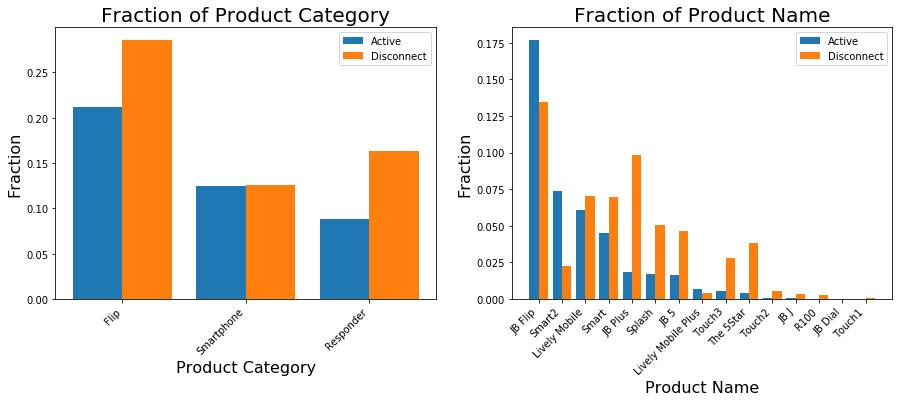

In [8]:
#Last Line of Service for each LastCust
#The distribution of product category and name for active and disconnected users
fig, ax = plt.subplots(1,2,figsize=(15,5))
LOSCustActive = LOSCust[LOSCust['LineStatusDesc']=='Active']
LOSCustDiscon = LOSCust[LOSCust['LineStatusDesc']!='Active']
ProdCat = pd.concat([LOSCustActive['LastDeviceProductCategory'].value_counts(),LOSCustDiscon['LastDeviceProductCategory'].value_counts()], axis=1, sort=False)
ProdName = pd.concat([LOSCustActive['LastDeviceProductName'].value_counts(), LOSCustDiscon['LastDeviceProductName'].value_counts()], axis=1, sort=False)

width = 0.4

##Look at what category of product has higher possibility to disconnect
CatLabel = ProdCat.index.values
CatValues = ProdCat.values/numCust
x = np.arange(len(CatLabel))
ax[0].bar(x - width/2, height=CatValues[:,0], width=width, label='Active')
ax[0].bar(x + width/2, height=CatValues[:,1], width=width, label='Disconnect')
ax[0].set_ylabel('Fraction', fontsize=16)
ax[0].set_xlabel('Product Category', fontsize=16)
ax[0].set_xticks(x)
ax[0].set_xticklabels(CatLabel, rotation=45, ha='right', va='top')
ax[0].set_title('Fraction of Product Category', fontsize=20)
ax[0].legend()

##Look at what product has higher possibility to disconnect
NameLabel = ProdName.index.values
NameValues = ProdName.values/numCust
x = np.arange(len(NameLabel))
ax[1].bar(x - width/2, height=NameValues[:,0], width=width, label='Active')
ax[1].bar(x + width/2, height=NameValues[:,1], width=width, label='Disconnect')
ax[1].set_ylabel('Fraction', fontsize=16)
ax[1].set_xlabel('Product Name', fontsize=16)
ax[1].set_xticks(x)
ax[1].set_xticklabels(NameLabel, rotation=45, ha='right', va='top')
ax[1].set_title('Fraction of Product Name', fontsize=20)
ax[1].legend()

It seems that some product categories and types have higher rate to disconnect

## Exploration on the Journals Table

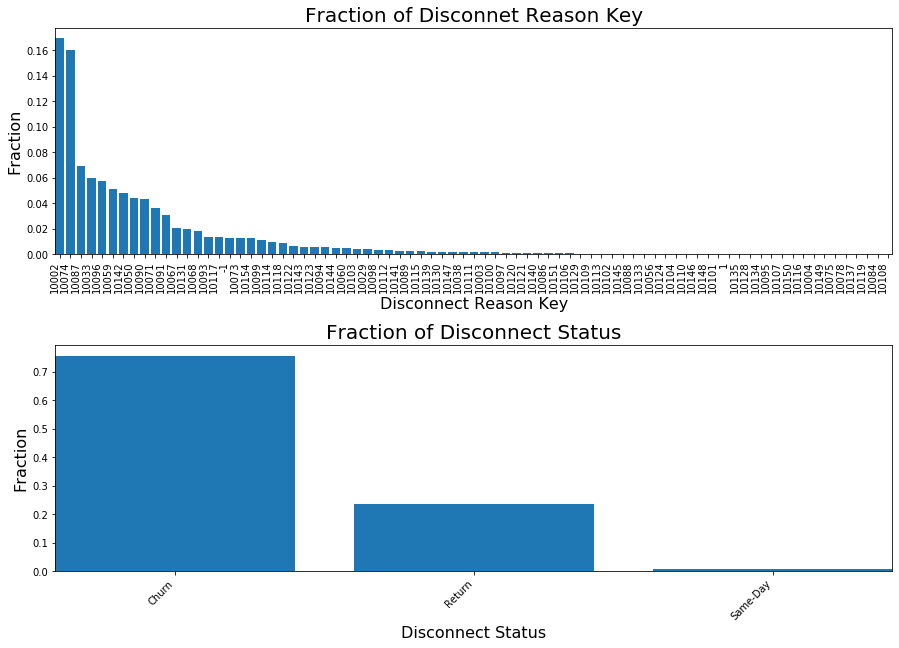

In [9]:
#Look at the reasons to disconnect
fig, ax = plt.subplots(2,1,figsize=(15,10))
DiscKey = LOSCustDiscon['LastDisconnectChgReasonKey'].value_counts()
DiscStatus = LOSCustDiscon['LineStatusDesc'].value_counts()
numDisc = LOSCustDiscon.shape[0]

##Look at what reasons prevail disconnection
KeyLabel = DiscKey.index.values
KeyValues = DiscKey.values/numDisc
x = np.arange(len(KeyLabel))
ax[0].bar(x, height=KeyValues, width=0.8)
ax[0].set_ylabel('Fraction', fontsize=16)
ax[0].set_xlabel('Disconnect Reason Key', fontsize=16)
ax[0].set_xticks(x)
ax[0].set_xlim(x[0]-0.4, x[-1]+0.4)
ax[0].set_xticklabels(KeyLabel, rotation=90, ha='right', va='top')
ax[0].set_title('Fraction of Disconnet Reason Key', fontsize=20)

##Look at what the results are for disconnection
StatusLabel = [x.split(' - ')[1].split()[0] for x in DiscStatus.index.values]
StatusValues = DiscStatus.values/numDisc
x = np.arange(len(StatusLabel))
ax[1].bar(x, height=StatusValues, width=0.8)
ax[1].set_ylabel('Fraction', fontsize=16)
ax[1].set_xlabel('Disconnect Status', fontsize=16)
ax[1].set_xticks(x)
ax[1].set_xlim(x[0]-0.4, x[-1]+0.4)
ax[1].set_xticklabels(StatusLabel, rotation=45, ha='right', va='top')
ax[1].set_title('Fraction of Disconnect Status', fontsize=20)

plt.subplots_adjust(hspace=0.4)

Try to find out if there are some reasons prevailing for disconnection. It seems there are definitely some main reasons for disconnection of service. The meaning of the reason code is unkown. Better understanding may help us to improve our products and services.

Text(0, 0.5, 'Fraction')

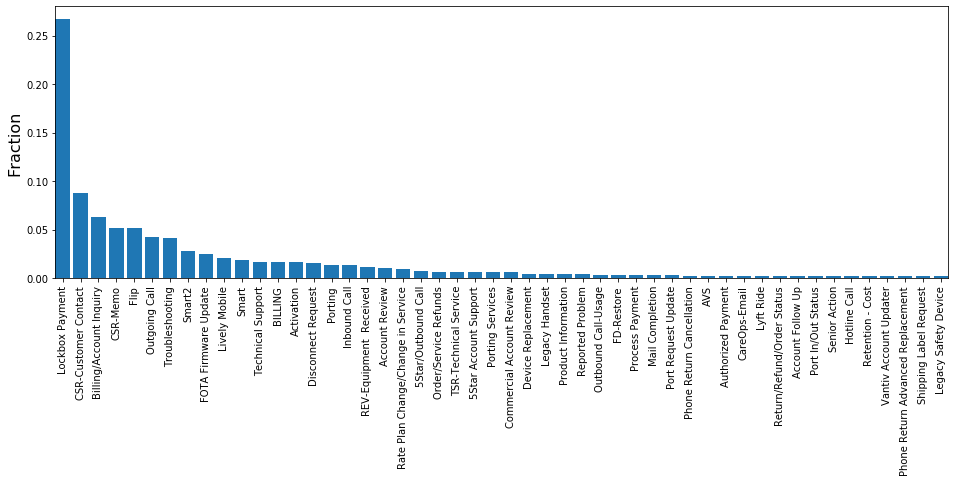

In [10]:
#Look at the distribution of reasons that a customer call in
numJournals=journals.shape[0]
commonCallType = journals['JournalTypeDesc'].value_counts()/numJournals
fig, ax = plt.subplots(1,1,figsize=(16,5))
x = np.arange(commonCallType.shape[0])
ax.bar(x[:50], height=commonCallType.values[:50], width=0.8)
ax.set_xticks(x[:50])
ax.set_xlim(x[0]-0.4, x[49]+0.4)
ax.set_xticklabels(commonCallType.index.values[:50], rotation=90, ha='center', va='top')
ax.set_ylabel('Fraction', fontsize=16)

What are the main reasons to call in. Should we have better manual, instructions for the customer to reduce number of calls?

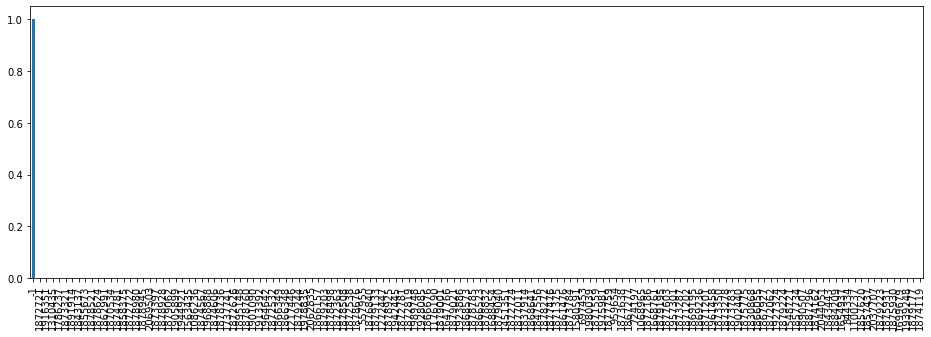

In [11]:
##To see if a specific LOS has more amount of calls
fig, ax = plt.subplots(1,1,figsize=(16,5))
(journals['LOSKey'].value_counts()/numJournals).plot(kind='bar', ax=ax)

Almost all calls are not for a specific LOS, but general purpose

In [12]:
#Volume of active customers per month (approximation) vs volume of call received
CustVol = lines[['LineStartDt', 'LastCustKey', 'LineStatusDesc']].copy()
CustVol['YearMonth'] = pd.to_datetime(CustVol['LineStartDt'].dt.strftime('%Y-%m'))
tmp_vol = []
for m in CustVol['YearMonth'].unique():
    tmp_vol.append([m, pd.concat([CustVol[(CustVol['YearMonth']<m) & (CustVol['LineStatusDesc']=='Active')], CustVol[CustVol['YearMonth']==m]], 
                       axis=0, sort=False)['LastCustKey'].unique().shape[0]
                   ])
CustVol = pd.DataFrame(tmp_vol, columns=['YearMonth', 'CustVol']).set_index('YearMonth')
journals['YearMonth'] = pd.to_datetime(journals['JournalCreateDtTm'].dt.strftime('%Y-%m'))
JournalVol = journals.groupby('YearMonth', sort=False).apply(lambda x: x['JournalKey'].shape[0])

vol = pd.concat([CustVol, JournalVol], axis=1, sort=False).reset_index().rename(columns={0:'JournalVol'})

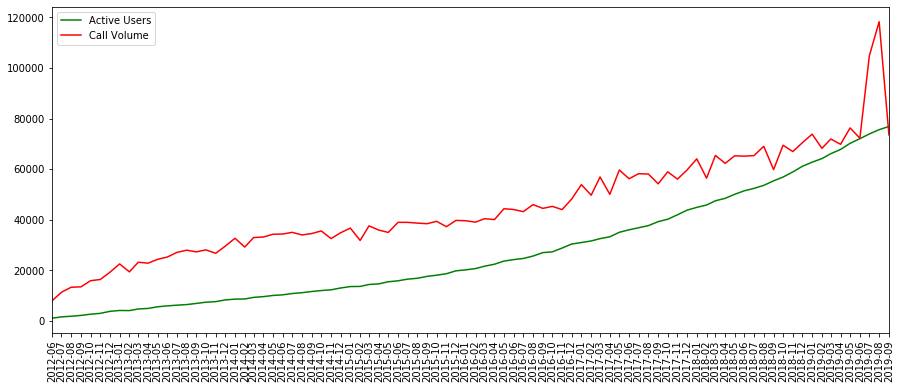

In [13]:
fig, ax = plt.subplots(1,1,figsize=(15,6))
ax.plot(vol['YearMonth'], vol['CustVol'], 'g', label='Active Users')
ax.plot(vol['YearMonth'], vol['JournalVol'], 'r', label='Call Volume')
months = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)
ax.set_xlim(vol['YearMonth'].values[0], vol['YearMonth'].values[-1])
ax.legend()
plt.tick_params(axis='x', rotation=90)

In general, the call volume raises as the number of active users increases, but not proportionally. It looks like there are much fewer calls per active customer towards lately. It will be interesting to dig more into it to see what drives the call volume. Especially what causes the spike in August, 2019? Anomaly on the call volume may suggest there are problems in production and vice verse. 

## Get joined info from Line Table and Journal Table

In [14]:
#Get the number of call-in and info about last call-in for each customer; do not include activation and disconnection calls
#as I would build a model to predict if a user will disconnect later
excludedCallReasons = ['Activation', 'Activation Support-CSR', 'Retail Activation Call-CSR', 
                      'Disconnect', 'Disconnect Request', 'Disconnect Account', 'Unpaid/Disconnect']
JournalCust = journals[~journals['JournalStatDesc'].isin(excludedCallReasons)].sort_values(by=['CustKey', 'JournalCreateDtTm']) \
                      .groupby('CustKey', sort=False)[['JournalTypeDesc','JournalStatDesc']] \
                      .apply(lambda x: pd.DataFrame([[x.shape[0]]+list(x.tail(1).values[0])], columns=['CallCount', 'LastJType', 'LastJStat']))
JournalCust = JournalCust.reset_index(level=1, drop=True)
JournalCust.head(2)

,CallCount,LastJType,LastJStat
CustKey,,,
41,98,Lockbox Payment,Lockbox Payment Received
83,14,FOTA Firmware Update,FOTA Completed


In [15]:
#Compute number of calls per day before a customer disconnects
LOSCust = LOSCust.rename(columns={'LastCustKey': 'CustKey'}).set_index('CustKey')
LOSCust = pd.concat([LOSCust, JournalCust], axis=1, sort=False) \
            .replace({'LineDisconnectDt':{None: np.datetime64('2019-09-20')},'CallCount':{None:0}}).fillna('')
LOSCust['ActiveDuration'] = (LOSCust['LineDisconnectDt']-LOSCust['LineStartDt']).dt.days
LOSCust['CallPerDay'] = LOSCust['CallCount']/LOSCust['ActiveDuration']
LOSCust.head(2)

,LineKey,LastDeviceKey,LastDeviceProductCategory,LastDeviceProductName,LastDisconnectChgReasonKey,LastLOSKey,LineStatusDesc,LineStartDt,LineDisconnectDt,CallCount,LastJType,LastJStat,ActiveDuration,CallPerDay
CustKey,,,,,,,,,,,,,,
41,1486025,1883866,Flip,JB 5,10120,1652358,Disconnected - Return,2015-07-26,2015-07-31,98.0,Lockbox Payment,Lockbox Payment Received,5,19.600000
83,2511050,3078230,Flip,JB Flip,-1,2933182,Active,2019-05-08,2019-09-20,14.0,FOTA Firmware Update,FOTA Completed,135,0.103704


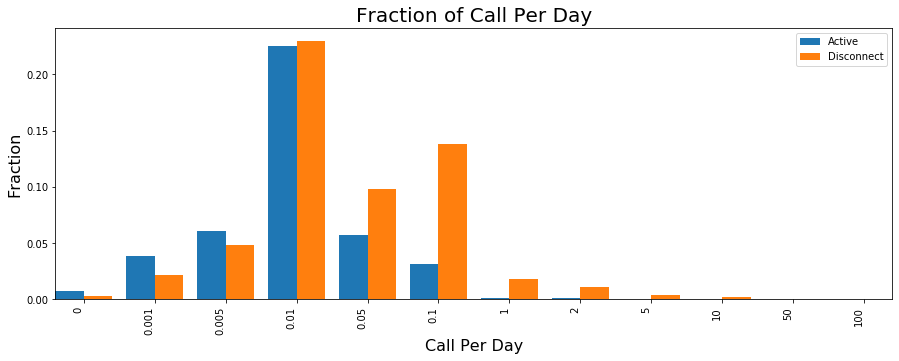

In [16]:
#Explore to see if there is correlation between number of calls per day and probability to disconnect
LOSCustActive = LOSCust[LOSCust['LineStatusDesc']=='Active']
LOSCustDiscon = LOSCust[LOSCust['LineStatusDesc']!='Active']
bins = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 2, 5, 10, 50, 100, 200]
ActiveCallPDay, _ = np.histogram(LOSCustActive['CallPerDay'], bins=bins)
DisconCallPDay, _ = np.histogram(LOSCustDiscon['CallPerDay'], bins=bins)
ActiveCallPDay = ActiveCallPDay/numCust
DisconCallPDay = DisconCallPDay/numCust

fig, ax = plt.subplots(1,1,figsize=(15,5))
width = 0.4

##Look at if number of calls per day has correlation with disconnection
x = np.arange(len(bins)-1)
ax.bar(x - width/2, height=ActiveCallPDay, width=width, label='Active')
ax.bar(x + width/2, height=DisconCallPDay, width=width, label='Disconnect')
ax.set_ylabel('Fraction', fontsize=16)
ax.set_xlabel('Call Per Day', fontsize=16)
ax.set_xticks(x)
ax.set_xlim(x[0]-0.4, x[-1]+0.4)
ax.set_xticklabels(bins, rotation=90, ha='right', va='top')
ax.set_title('Fraction of Call Per Day', fontsize=20)
ax.legend()

As only suggested by the plot above, it seems that larger number of calls per day implies higher posibility to disconnect. 

## Get Some Statistics from Invoice Table

In [17]:
invoices['YearMonth'] = pd.to_datetime(invoices['InvoiceDt'].dt.strftime('%Y-%m'))
invoiceMonthly = invoices.groupby(['CustKey', 'YearMonth'], as_index=False, sort=False)['InvoiceTtlAmtDue'].sum()

In [18]:
def invoiceAmtStat(x):
    totalMonths = 12*(x['YearMonth'].dt.year.max() - x['YearMonth'].dt.year.min()) \
                  + (x['YearMonth'].max().month - x['YearMonth'].min().month) + 1
    avgAmt = x['InvoiceTtlAmtDue'].sum()/totalMonths
    seg1 = 1 if totalMonths//3==0 else totalMonths//3
    seg3 = seg1
    seg1_avg = x.head(seg1)['InvoiceTtlAmtDue'].sum()/seg1
    seg3_avg = x.tail(seg3)['InvoiceTtlAmtDue'].sum()/seg3
    if seg1_avg==0:
        if seg3_avg==0:
            ratio31 = 1
        else:
            ratio31 = 1000
    else:
        ratio31 = seg3_avg/seg1_avg
    if totalMonths>=3:
        seg2 = totalMonths - seg1 - seg3
        seg2_avg = x.tail(totalMonths-seg1).head(seg2)['InvoiceTtlAmtDue'].sum()/seg2
        if seg2_avg==0:
            if seg3_avg==0:
                ratio32 = 1
            else:
                ratio32 = 1000
        else:
            ratio32 = seg3_avg/seg2_avg
    else:
        seg2 = 100
        seg2_avg = 10000
        ratio32 = ratio31
        
    return pd.DataFrame([[avgAmt, ratio31, ratio32]], columns=['AvgAmt', 'AmtRatio1', 'AmtRatio2'])

In [19]:
invoiceCust = invoiceMonthly.sort_values(['CustKey','YearMonth']) \
                            .groupby('CustKey', sort=False) \
                            .apply(lambda x: invoiceAmtStat(x)) \
                            .reset_index(level=1, drop=True)
invoiceCust.head(2)

,AvgAmt,AmtRatio1,AmtRatio2
CustKey,,,
41,20.957614,1.737803,1.210821
83,19.364091,1.183864,1.237222


In [20]:
LOSCust = pd.concat([LOSCust, invoiceCust], axis=1, sort=False, join='inner')

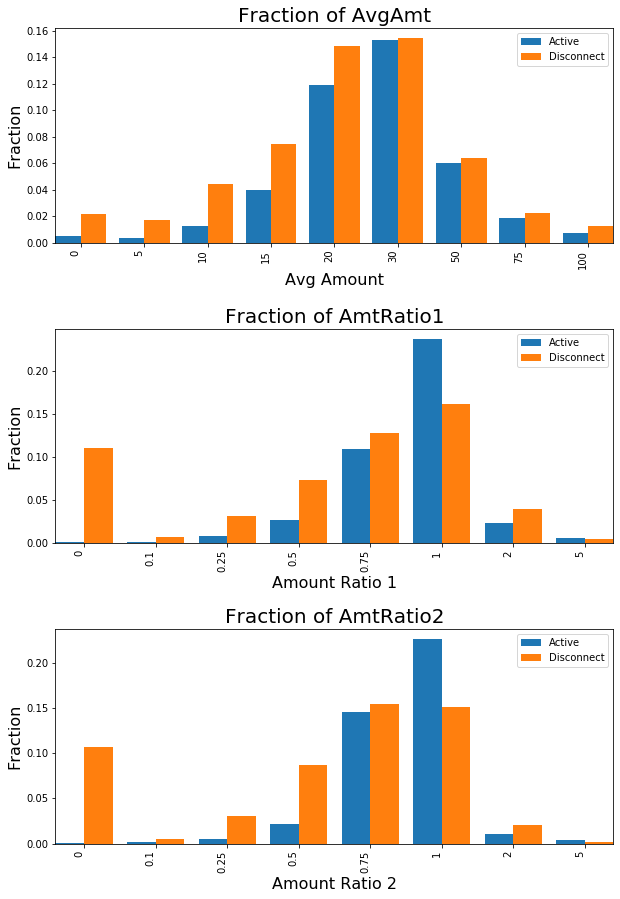

In [21]:
#if there is corelation between invoice stats and probability to disconnect
LOSCustActive = LOSCust[LOSCust['LineStatusDesc']=='Active']
LOSCustDiscon = LOSCust[LOSCust['LineStatusDesc']!='Active']

fig, ax = plt.subplots(3,1,figsize=(10,15))
width = 0.4

##Look at distribution of avg amt
bins = [0, 5, 10, 15, 20, 30, 50, 75, 100, 150]
ActiveAvgAmt, _ = np.histogram(LOSCustActive['AvgAmt'], bins=bins)
DisconAvgAmt, _ = np.histogram(LOSCustDiscon['AvgAmt'], bins=bins)
ActiveAvgAmt = ActiveAvgAmt/numCust
DisconAvgAmt = DisconAvgAmt/numCust

x = np.arange(len(bins)-1)
ax[0].bar(x - width/2, height=ActiveAvgAmt, width=width, label='Active')
ax[0].bar(x + width/2, height=DisconAvgAmt, width=width, label='Disconnect')
ax[0].set_ylabel('Fraction', fontsize=16)
ax[0].set_xlabel('Avg Amount', fontsize=16)
ax[0].set_xticks(x)
ax[0].set_xlim(x[0]-0.4, x[-1]+0.4)
ax[0].set_xticklabels(bins, rotation=90, ha='right', va='top')
ax[0].set_title('Fraction of AvgAmt', fontsize=20)
ax[0].legend()

##Look at distribution of amt ratio of latest payments to the earliest payments
bins = [0, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10]
ActiveRatio1, _ = np.histogram(LOSCustActive['AmtRatio1'], bins=bins)
DisconRatio1, _ = np.histogram(LOSCustDiscon['AmtRatio1'], bins=bins)
ActiveRatio1 = ActiveRatio1/numCust
DisconRatio1 = DisconRatio1/numCust

x = np.arange(len(bins)-1)
ax[1].bar(x - width/2, height=ActiveRatio1, width=width, label='Active')
ax[1].bar(x + width/2, height=DisconRatio1, width=width, label='Disconnect')
ax[1].set_ylabel('Fraction', fontsize=16)
ax[1].set_xlabel('Amount Ratio 1', fontsize=16)
ax[1].set_xticks(x)
ax[1].set_xlim(x[0]-0.4, x[-1]+0.4)
ax[1].set_xticklabels(bins, rotation=90, ha='right', va='top')
ax[1].set_title('Fraction of AmtRatio1', fontsize=20)
ax[1].legend()

##Look at distribution of amt ratio of latest payments to intermediate payments
bins = [0, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10]
ActiveRatio2, _ = np.histogram(LOSCustActive['AmtRatio2'], bins=bins)
DisconRatio2, _ = np.histogram(LOSCustDiscon['AmtRatio2'], bins=bins)
ActiveRatio2 = ActiveRatio2/numCust
DisconRatio2 = DisconRatio2/numCust

x = np.arange(len(bins)-1)
ax[2].bar(x - width/2, height=ActiveRatio2, width=width, label='Active')
ax[2].bar(x + width/2, height=DisconRatio2, width=width, label='Disconnect')
ax[2].set_ylabel('Fraction', fontsize=16)
ax[2].set_xlabel('Amount Ratio 2', fontsize=16)
ax[2].set_xticks(x)
ax[2].set_xlim(x[0]-0.4, x[-1]+0.4)
ax[2].set_xticklabels(bins, rotation=90, ha='right', va='top')
ax[2].set_title('Fraction of AmtRatio2', fontsize=20)
ax[2].legend()

plt.subplots_adjust(hspace=0.4)

It looks like the stats extracted from invoice table exhibit some different patterns for active users and disconnected users. However, it is a little bit counter-intuitive to myself; for example, I originally thought a users may be more possible to disconnect if the payment increases, but it does not seem like this, at least not obviously.

## Attempt to Predict if a User is going to disconnect

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import catboost as cb

In [23]:
#For those customers who just start the service recently, I exclude them as there are not enough history for those
LOSCust = LOSCust[LOSCust['LineStartDt']<np.datetime64('2019-09-01')] #this is arbitrary

#Create label for the classification
LOSCust['Target'] = 1
LOSCust.loc[LOSCust['LineStatusDesc']=='Active', 'Target'] = 0

#Keep only the "features" and target columns
featureCols = ['LastDeviceProductCategory', 'LastDeviceProductName', 'CallPerDay', 'LastJType', 'LastJStat', 'AvgAmt', 'AmtRatio1', 'AmtRatio2']
features = LOSCust[featureCols]
targets = LOSCust['Target']

#Split the data into train and test
train_x, test_x, train_y, test_y = train_test_split(features, targets, test_size=0.2, random_state=123)

In [24]:
#Check if the fraction of positive labels are similar in train and test datasets
train_y.sum()/train_y.shape[0], test_y.sum()/test_y.shape[0]

(0.5785879548482087, 0.5811599080150317)

It also suggests that labels of 0 and 1 are slightly imbalanced, but not huge to require upsampling or downsampling

In [25]:
def auc(m, train_y, train_x, test_y, test_x): 
    return (roc_auc_score(train_y,m.predict_proba(train_x)[:,1]),
            roc_auc_score(test_y,m.predict_proba(test_x)[:,1]))

In [26]:
cat_features_index = [0,1,3,4]

params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.2],
          'l2_leaf_reg': [1, 4, 9]}
cbt = cb.CatBoostClassifier(iterations=300, eval_metric='AUC', cat_features=cat_features_index, logging_level='Silent')
cb_model = GridSearchCV(cbt, params, scoring='roc_auc', cv = 3)
cb_model.fit(train_x, train_y)

clf = cb_model.best_estimator_

print("Best Model Performance:\n", auc(clf, train_y, train_x, test_y, test_x))

cb_model.best_params_

Best Model Performance:
 (0.9798049026147871, 0.975462048616436)


{'depth': 7, 'l2_leaf_reg': 9, 'learning_rate': 0.2}

Text(0.5, 0, '')

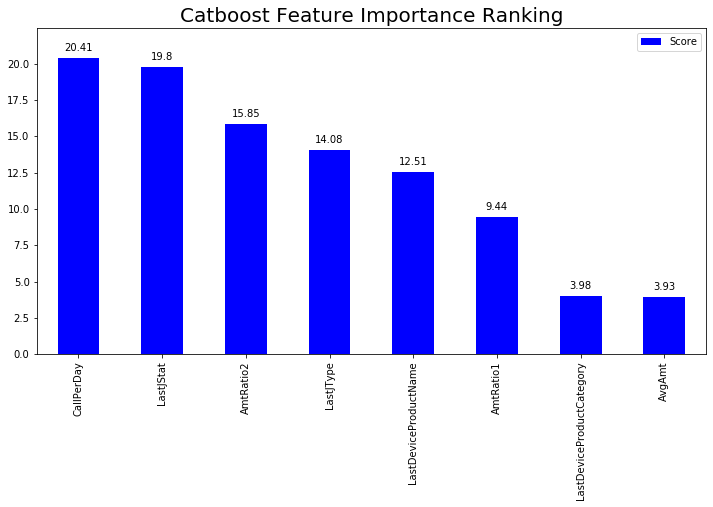

In [27]:
#Look at the feature importances
feature_score = pd.DataFrame(list(zip(featureCols, clf.get_feature_importance(cb.Pool(train_x, label=train_y, cat_features=cat_features_index)))),
                columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, na_position='last')

fig, ax = plt.subplots(1,1,figsize=(12,6))
feature_score.plot('Feature', 'Score', kind='bar', color='b', ax=ax)

rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

ax.set_title("Catboost Feature Importance Ranking", fontsize = 20)
ax.set_ylim(0, feature_score['Score'].max()*1.1)
ax.set_xlabel('')

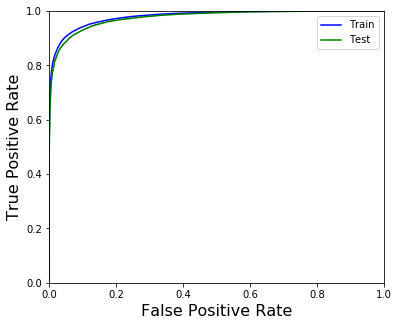

In [28]:
#Look at the ROC curve
fpr1, tpr1, thr1 = roc_curve(train_y, clf.predict_proba(train_x)[:,1])
fpr2, tpr2, thr2 = roc_curve(test_y, clf.predict_proba(test_x)[:,1])
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.plot(fpr1, tpr1, 'b-', label='Train')
ax.plot(fpr2, tpr2, 'g-', label='Test')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.legend()

In [29]:
# In order to detect as many customers who is going to truely disconnect, 
# we could tolerate a slightly higher false positive rate if true positive rate increases "significantly"
# Based on the ROC curve above, false positive rate between 0.2 and 0.25 is acceptable, the threshold is around 0.20
train_pred = clf.predict_proba(train_x)[:,1]
train_pred[train_pred<=0.2] = 0
train_pred[train_pred>0.2] = 1
test_pred = clf.predict_proba(test_x)[:,1]
test_pred[test_pred<=0.2] = 0
test_pred[test_pred>0.2] = 1

print("Train Acc: {:.2f}%, Test Acc: {:.2f}%".format((train_y.values==train_pred).sum()/train_y.shape[0]*100, (test_y.values==test_pred).sum()/test_y.shape[0]*100))
print("Train Detection Rate: {:.2f}%, Test Detection Rate: {:.2f}%".format(((train_y.values+train_pred)==2).sum()/train_y.sum()*100, ((test_y.values+test_pred)==2).sum()/test_y.sum()*100))

Train Acc: 89.47%, Test Acc: 88.89%
Train Detection Rate: 97.50%, Test Detection Rate: 97.02%


## Thoughts

Using the provided datasets, there are lots of things we could do through data mining and data modeling. For example, how we could improve the products, services and user manuals; how to promote some products/services because of better satisfication rate; how we could predict the call volume in the call center, and if the volume increase could help us to identify production issues in time and vice verse; the last but not the least, what is the better strategy for billing.

In this assessment, I mainly focused on predict if a customer is going to disconnect, for fun. I do not know how meaningful this is, but I just quickly formed some features and used CatBoost classifier to build a model. I even did not spend much time on cleaning the features (e.g. careful imputation, dealing with outliers). Surprisingly the simple model could achieve accuracy of ~90% and detection rate of disconnected users of ~97%, without obvious overfitting, after choosing the appropriate threshold. A few findings include: 1) number of calls per day seems a strong indicator if a customer is going to disconnect; 2) it is important to pay more attention to certain JournalStat (not analyzed yet) as it also contributes more significantly to disconnection; 3) billing seems have effect on disconnection but it is not the average amount to be charged (need to look at it closer); and more.

## Next Steps

Generally speaking, understand the data more and better. There are more things we could do using these datasets.

For the model I built here, 1) look closer to impute and deal with outliers in the features (e.g. invoice table has large negative values, what does it mean?); 2) more features should be engineered when better understanding of the data is achieved; 3) further tune the parameters in the model (currently a quick/simple GridSearchCV is used; it takes time to run more searches/tunes); 4) analyze the error cases and gain more insights for 2); 5) Try different models (then standardization, normalization, and other feature pre-processing may be needed for some types of models) and see if improved; 6) Analyze some features in-depth and see if we could do better in retaining/helping customers when the model achieves satisfactory performance and we select a few important features.